In [1]:
import os
import numpy
import tensorflow
import librosa
from torch.utils.data import Dataset,TensorDataset,DataLoader
from dataclasses import dataclass
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

In [2]:
def to_device(data,device):
    if isinstance(data,(tuple,list)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [3]:
class DeviceDataLoader:
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,self.device)
    def __len__(self):
        return len(self.dl)

In [36]:
def augment_by_genre(y, sr, genre):
    if genre in [5, 2]:
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))
    if genre in [9, 3]:
        y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.85, 1.15))
    if genre in [5, 9, 7]:
        y += np.random.normal(0, 0.003, y.shape)  # background noise
    return y

def normalize(x):
    return (x - np.mean(x)) / (np.std(x) + 1e-6)


In [127]:
def transform(waveform):
    if(len(waveform)<66150):
        waveform = np.pad(waveform, (0, max(0, 66150 - len(waveform))), mode='constant')
    else: waveform=waveform[:66150]
    mfcc = librosa.feature.mfcc(y=waveform, sr=22050, n_mfcc=40)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    tempo, beats = librosa.beat.beat_track(y=waveform, sr=22050)
    tempo_ = librosa.util.sync(mfcc, beats)
    tempo_tensor = torch.tensor(tempo_, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    tempo_resized = F.interpolate(tempo_tensor, size=(40, 130), mode='bilinear', align_corners=False)
    tempo_resized = tempo_resized.squeeze(0).squeeze(0)
    tempo_resized = np.array(tempo_resized)
    chroma = librosa.feature.chroma_stft(y=waveform, sr=22050)
    chroma_tensor = torch.tensor(chroma, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    chroma_resized = F.interpolate(chroma_tensor, size=(40, 130), mode='bilinear', align_corners=False)
    chroma_resized = chroma_resized.squeeze(0).squeeze(0)
    chroma_resized = np.array(chroma_resized)
    im2d = np.stack([mfcc, delta, delta2, tempo_resized, chroma_resized], axis=-1)
    # im2d = torch.tensor(im2d)
    return im2d



@dataclass
class gtzan(Dataset):
    def __init__(self,file_path,transform=None):
        self.labels=[]
        self.file_paths=[]
        self.transform=transform
        for i,label in enumerate(sorted(os.listdir(file_path))):
            label_dir=os.path.join(file_path,label)
            if not os.path.isdir(label_dir):
                continue
            self.labels.append(label)
            for file_name in os.listdir(label_dir):
                if(file_name.endswith(".au")):
                    self.file_paths.append((os.path.join(label_dir,file_name),i))
    def __iter__(self):
        for file_path,label in self.file_paths:
            yield file_path,label
    def __len__(self):
        return len(self.file_paths)
    def get(self):
        x=[]
        y=[]
        for file_path,label in self.file_paths:
            if(os.path.exists(file_path)):
                waveform,_ = librosa.load(file_path,sr=22050,mono=True)
                for i in range(10):
                    start = i * 66150
                    end = start + 66150
                    chunk = waveform[start:end]
                    # chunk_a = augment_by_genre(chunk,22050,label)
                    chunk=self.transform(chunk)
                    x.append(chunk)
                    y.append(label)
                    # if label in [5, 2, 9, 3, 7]:
                    #     chunk = self.transform(chunk)
                    #     x.append(chunk)
                    #     y.append(label)
        return x,y


In [128]:
dataset = gtzan('genres',transform)

In [129]:
xls,yls= dataset.get()

In [131]:
xls = np.array(xls)
yls = np.array(yls)

In [132]:
print(xls.shape)
yls.shape

(10000, 40, 130, 5)


(10000,)

In [133]:
x_train,x_test,y_train,y_test = train_test_split(xls,yls,random_state=42,test_size=0.2,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,random_state=42,test_size=0.2,shuffle=True)

In [134]:
device = torch.device("cuda")
x_train = torch.tensor(x_train).permute(0,3,1,2)
x_test = torch.tensor(x_test).permute(0,3,1,2)
x_val = torch.tensor(x_val).permute(0,3,1,2)
y_train = torch.tensor(y_train).long()
y_test = torch.tensor(y_test).long()
y_val = torch.tensor(y_val).long()
train_dataset = TensorDataset(x_train,y_train)
test_dataset = TensorDataset(x_test,y_test)
val_dataset = TensorDataset(x_val,y_val)
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=True)
train_dataloader = DeviceDataLoader(train_loader,device)
test_dataloader = DeviceDataLoader(test_loader,device)
val_dataloader = DeviceDataLoader(val_loader,device)

In [138]:

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=32, kernel_size=3, padding=1),  # same padding
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Mimics GlobalAveragePooling2D
        self.fc1 = nn.Linear(64, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.3)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn_fc(x)
        x = self.dropout_fc(x)
        x = self.out(x)
        return F.log_softmax(x, dim=1)  # log_softmax for NLLLoss, or softmax if using CrossEntropyLoss

# Model instance
model = CNNClassifier()
print(model)
model.to(device)


CNNClassifier(
  (block1): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (bn_fc): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_fc): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


CNNClassifier(
  (block1): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (bn_fc): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_fc): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [140]:
from torch.cuda.amp import GradScaler
from torchmetrics.classification import Accuracy  # Optional: for clean accuracy calc

scaler = GradScaler()
train_acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)
val_acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
val_losses = []
train_losses = []
for epoch in range(1, 50 + 1):
    # ----------------------
    #       Training
    # ----------------------
    model.train()
    running_train_loss = 0.0
    train_acc_metric.reset()

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item()
        train_acc_metric.update(preds, yb)

    train_loss = running_train_loss / len(train_loader)
    train_acc = train_acc_metric.compute().item()
    train_losses.append(train_loss)

    # ----------------------
    #     Validation
    # ----------------------
    model.eval()
    running_val_loss = 0.0
    val_acc_metric.reset()

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            running_val_loss += loss.item()
            val_acc_metric.update(preds, yb)

    val_loss = running_val_loss / len(val_loader)
    val_acc = val_acc_metric.compute().item()
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


C:\Users\raman\AppData\Local\Temp\ipykernel_25128\1240277786.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 01 | Train Loss: 0.4758 | Train Acc: 0.8394 | Val Loss: 0.4789 | Val Acc: 0.8369
Epoch 02 | Train Loss: 0.4652 | Train Acc: 0.8370 | Val Loss: 0.4613 | Val Acc: 0.8475
Epoch 03 | Train Loss: 0.4628 | Train Acc: 0.8395 | Val Loss: 0.4514 | Val Acc: 0.8438
Epoch 04 | Train Loss: 0.4494 | Train Acc: 0.8477 | Val Loss: 0.4642 | Val Acc: 0.8431
Epoch 05 | Train Loss: 0.4541 | Train Acc: 0.8459 | Val Loss: 0.4481 | Val Acc: 0.8512
Epoch 06 | Train Loss: 0.4520 | Train Acc: 0.8420 | Val Loss: 0.4672 | Val Acc: 0.8356
Epoch 07 | Train Loss: 0.4335 | Train Acc: 0.8508 | Val Loss: 0.4494 | Val Acc: 0.8450
Epoch 08 | Train Loss: 0.4412 | Train Acc: 0.8470 | Val Loss: 0.4383 | Val Acc: 0.8494
Epoch 09 | Train Loss: 0.4495 | Train Acc: 0.8481 | Val Loss: 0.4457 | Val Acc: 0.8444
Epoch 10 | Train Loss: 0.4347 | Train Acc: 0.8517 | Val Loss: 0.4285 | Val Acc: 0.8512
Epoch 11 | Train Loss: 0.4284 | Train Acc: 0.8481 | Val Loss: 0.4163 | Val Acc: 0.8606
Epoch 12 | Train Loss: 0.4398 | Train Acc: 

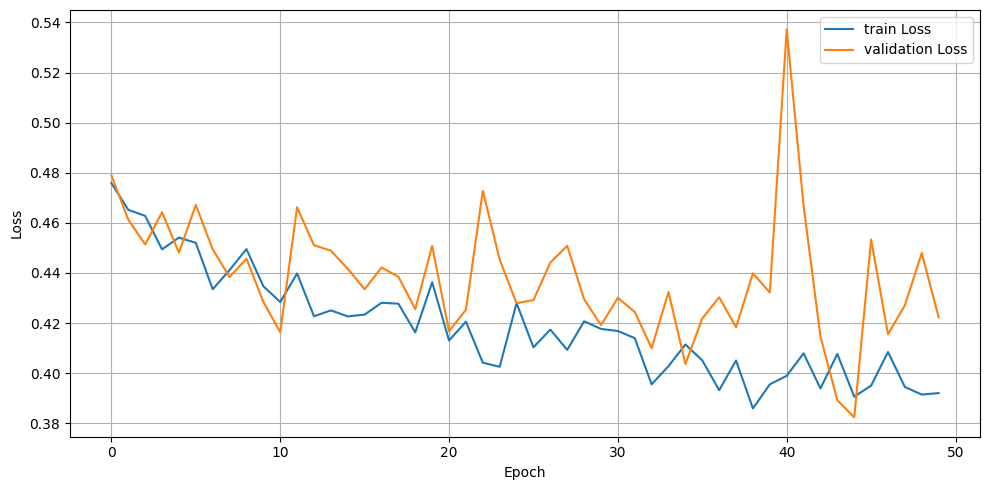

In [148]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train Loss')
plt.plot(val_losses, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
test_acc_metric = Accuracy(task='multiclass', num_classes=10).to(device)
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        test_acc_metric.update(preds, yb)
        predicted = preds.argmax(dim=1).cpu().numpy()
        all_preds.extend(predicted)
        all_labels.extend(yb.cpu().numpy())
test_accuracy = test_acc_metric.compute().item()
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8590


In [143]:
check_point = {
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict(),
    "train_acc":train_acc,
    "val_acc":val_acc,
    "train_losses":train_losses,
    "val_losses":val_losses,
    "test_acc":test_accuracy,
    "epoch":"15e-4 and 1e-4"}
torch.save(check_point, "ckpt/withweightdecay5channels.ckpt")


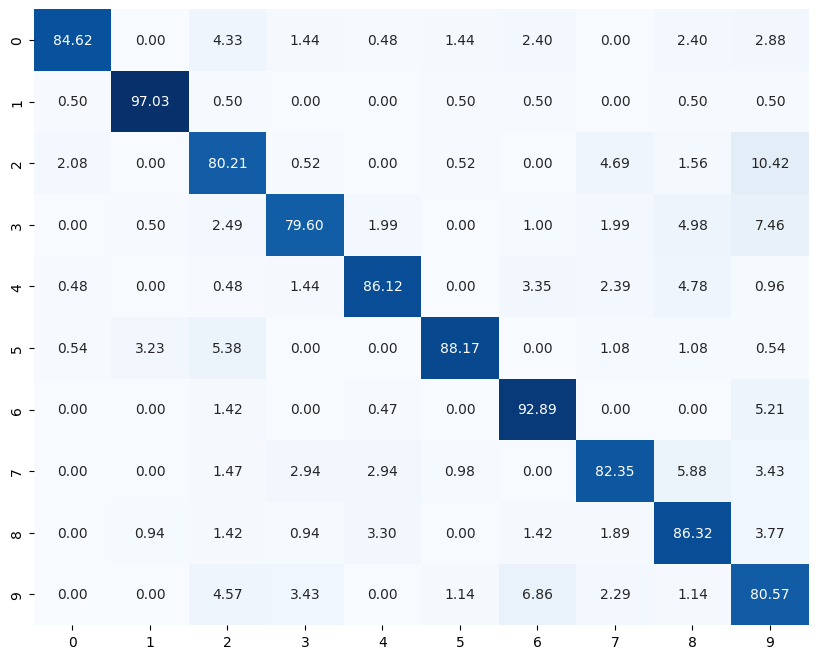

In [144]:
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False)

In [146]:
model.eval()
count = 0
total = 0
for xi,yi in dataset:
    x = []
    y = []
waveform,_ = librosa.load(xi,sr=22050,mono=True)
for i in range(10):
                start = i * 66150
                end = start + 66150
                chunk = waveform[start:end]
                chunk = transform(chunk)
                x.append(chunk)
                count += 1
x = torch.tensor(x).permute(0,3,1,2).to(device)
pred = model(x)
pred = pred.argmax(dim=1)
total+=torch.sum(pred != yi).item()
print(total/count)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
0.2


In [152]:
from flask import Flask,render_template,request,jsonify
from flask_wtf import FlaskForm
from wtforms import FileField,SubmitField
from wtforms.validators import DataRequired

In [235]:
app = Flask(__name__)
app.secret_key = 'nummadethamarasserychoramnu'
app.config["SQLALCHEMY_TRACK_MODIFICATIONS"] = False

In [236]:
class Myform(FlaskForm):
    audio = FileField('Audio', validators=[DataRequired()])
    submit = SubmitField('submit')

In [237]:
@app.route('/')
def index():
    form = Myform()
    return render_template('index.html',form=form)
@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    file = request.files["file"]
    try:
        y, _ = librosa.load(file, sr=22050,mono=True)
        l = len(y)
        i=1
        x = []
        while(i*66150<l and i<10):
            start = i*66150
            end = start+66150
            chunk = y[start:end]
            if len(chunk)<66150:
                break
            chunk = transform(chunk)
            if len(chunk.shape)!=3 or 0 in chunk.shape:
                i+=1
                continue
            x.append(chunk)
            i+=1
        x = torch.tensor(x).permute(0,3,1,2).to(device)
        pred = model(x)
        pred = pred.argmax(dim=1)
        unique_vals, counts = torch.unique(pred, return_counts=True)
        max_count_index = torch.argmax(counts)
        most_frequent = unique_vals[max_count_index].item()
        print(pred)
        return jsonify({"genre": dataset.labels[pred]})
    except Exception as e:
        return jsonify({"error": str(e)}), 500



In [238]:
if __name__ == "__main__":
    app.run(debug=True,use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [23/Jun/2025 01:13:05] "POST /predict HTTP/1.1" 500 -


tensor([9, 9, 3, 9, 9, 9, 9, 9, 9], device='cuda:0')
